In [24]:
from langgraph.graph import MessagesState
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, RemoveMessage
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import InMemorySaver

In [25]:
load_dotenv()

True

In [26]:
model = ChatOpenAI()

In [27]:
class ChatState(MessagesState):
    summary: str

In [28]:
def summarize_conversation(state: ChatState):

    existing_summary = state["summary"]

    # Build summarization prompt
    if existing_summary:
        prompt = (
            f"Existing summary:\n{existing_summary}\n\n"
            "Extend the summary using the new conversation above."
        )
    else:
        prompt = "Summarize the conversation above."

    messages_for_summary = state["messages"] + [
        HumanMessage(content=prompt)
    ]

    response = model.invoke(messages_for_summary)

    # Keep only last 2 messages verbatim
    messages_to_delete = state["messages"][:-2]

    return {
        "summary": response.content,
        "messages": [RemoveMessage(id=m.id) for m in messages_to_delete],
    }

In [29]:
def chat_node(state: ChatState):
    messages = []

    if state["summary"]:
        messages.append({
            "role": "system",
            "content": f"Conversation summary:\n{state['summary']}"
        })

    messages.extend(state["messages"])

    print(messages)

    response = model.invoke(messages)
    return {"messages": [response]}

In [30]:
def should_summarize(state: ChatState):
    return len(state["messages"]) > 6

In [31]:
builder = StateGraph(ChatState)

builder.add_node("chat", chat_node)
builder.add_node("summarize", summarize_conversation)

builder.add_edge(START, "chat")

builder.add_conditional_edges(
    "chat",
    should_summarize,
    {
        True: "summarize",
        False: "__end__",
    }
)

builder.add_edge("summarize", "__end__")



In [32]:
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

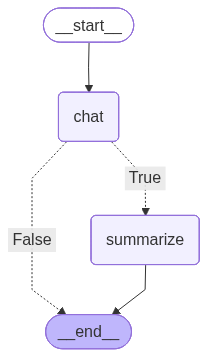

In [33]:
graph

In [34]:
config = {"configurable": {"thread_id": "t1"}}

def run_turn(text: str):
    out = graph.invoke({"messages": [HumanMessage(content=text)], "summary": ""}, config=config)
    return out

In [35]:
# gives the current version of the state
def show_state():
    snap = graph.get_state(config)
    vals = snap.values
    print("\n--- STATE ---")
    print("summary:", vals.get("summary", ""))
    print("num_messages:", len(vals.get("messages", [])))
    print("messages:")
    for m in vals.get("messages", []):
        print("-", type(m).__name__, ":", m.content[:80])

In [36]:
run_turn('Quantum Physics')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='df473619-8d6e-4f11-bb29-e8745cb95f8b')]

--- STATE ---
summary: 
num_messages: 2
messages:
- HumanMessage : Quantum Physics
- AIMessage : Quantum physics, also known as quantum mechanics, is the branch of physics that 


In [37]:
run_turn('How is Albert Einstien related?')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='df473619-8d6e-4f11-bb29-e8745cb95f8b'), AIMessage(content='Quantum physics, also known as quantum mechanics, is the branch of physics that describes the behavior of matter and energy on the smallest scales of atoms and subatomic particles. It is a fundamental theory in physics that explains the behavior of particles and waves at the atomic and subatomic levels.\n\nOne of the key principles of quantum physics is that particles can exist in multiple states at the same time, a concept known as superposition. Another important principle is the idea of quantum entanglement, where particles become correlated in a way that their quantum states are intertwined, even when separated by large distances.\n\nQuantum physics has led to the development of many technologies, such as quantum computing and quantum cryptography, that have the potential to revolutionize the way we process information and secure commun

In [38]:
run_turn('What are some of Einstien"s fampus work')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='df473619-8d6e-4f11-bb29-e8745cb95f8b'), AIMessage(content='Quantum physics, also known as quantum mechanics, is the branch of physics that describes the behavior of matter and energy on the smallest scales of atoms and subatomic particles. It is a fundamental theory in physics that explains the behavior of particles and waves at the atomic and subatomic levels.\n\nOne of the key principles of quantum physics is that particles can exist in multiple states at the same time, a concept known as superposition. Another important principle is the idea of quantum entanglement, where particles become correlated in a way that their quantum states are intertwined, even when separated by large distances.\n\nQuantum physics has led to the development of many technologies, such as quantum computing and quantum cryptography, that have the potential to revolutionize the way we process information and secure commun

In [39]:
run_turn('Explain special theory of relativity')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='df473619-8d6e-4f11-bb29-e8745cb95f8b'), AIMessage(content='Quantum physics, also known as quantum mechanics, is the branch of physics that describes the behavior of matter and energy on the smallest scales of atoms and subatomic particles. It is a fundamental theory in physics that explains the behavior of particles and waves at the atomic and subatomic levels.\n\nOne of the key principles of quantum physics is that particles can exist in multiple states at the same time, a concept known as superposition. Another important principle is the idea of quantum entanglement, where particles become correlated in a way that their quantum states are intertwined, even when separated by large distances.\n\nQuantum physics has led to the development of many technologies, such as quantum computing and quantum cryptography, that have the potential to revolutionize the way we process information and secure commun